<a href="https://colab.research.google.com/github/iamprakashom/NLP-with-Deep-Learning/blob/master/Transfer_Learning_using_ULMFit_for_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Install required library
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html


In [0]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [0]:
# Import 20 newsgroup dataset
from sklearn.datasets import fetch_20newsgroups

In [0]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('header', 'footers', 'quotes'))

In [5]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [6]:
dataset.target

array([17,  0, 17, 11, ..., 13,  9,  4,  9])

In [8]:
dataset.data[:5]

['From: ab4z@Virginia.EDU ("Andi Beyer")\nSubject: Re: Israeli Terrorism\nOrganization: University of Virginia\nLines: 15',
 "From: timmbake@mcl.ucsb.edu (Bake Timmons)\nSubject: Re: Amusing atheists and agnostics\nLines: 66\n\n\n\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap of faith, Jimmy.  Your logic runs out\nof steam!\n\n\n\n\n\n\n\nJim,\n\nSorry I can't pity you, Jim.  And I'm sorry that you have these feelings of\ndenial about the faith you need to get by.  Oh well, just pretend that it will\nall end happily ever after anyway.  Maybe if you start a new newsgroup,\nalt.atheist.hard, you won't be bummin' so much?\n\n\n\n\n\n\nBye-Bye, Big Jim.  Don't forget your Flintstone's Chewables!  :) \n--\nBake Timmons, III",
 "From: bc744@cleveland.Freenet.Edu (Mark Ira Kaufman)\nSubject: Re: rejoinder. Questions to Israelis\nOrganization: Case Western Reserve University, Cleveland, Ohio (USA)\nLines: 38\nNNTP-P

In [0]:
#Let’s create a dataframe consisting of the text documents and their corresponding labels (newsgroup names).
df = pd.DataFrame({'text': dataset.data, 'label': dataset.target, })

In [10]:
df.head()

,text,label
0,"From: ab4z@Virginia.EDU (""Andi Beyer"")\nSubjec...",17
1,From: timmbake@mcl.ucsb.edu (Bake Timmons)\nSu...,0
2,From: bc744@cleveland.Freenet.Edu (Mark Ira Ka...,17
3,From: ray@ole.cdac.com (Ray Berry)\nSubject: C...,11
4,From: kkeller@mail.sas.upenn.edu (Keith Keller...,10


In [11]:
df.shape

(11314, 2)

We’ll convert this into a binary classification problem by selecting only 2 out of the 20 labels present in the dataset. We will select labels 1 and 10 which correspond to **‘comp.graphics**’ and ‘**rec.sport.hockey**’, respectively.

In [0]:
df = df[df['label'].isin([1,10])]

In [13]:
df.head()

,text,label
4,From: kkeller@mail.sas.upenn.edu (Keith Keller...,10
10,From: nfotis@ntua.gr (Nick C. Fotis)\nSubject:...,1
17,From: jwh@sei.cmu.edu (John Huber)\nSubject: R...,10
24,From: jimg@cybernet.cse.fau.edu (Jim Gorycki)\...,10
28,From: farenebt@craft.camp.clarkson.edu (Droopy...,10


In [14]:
df['label'].unique()

array([10,  1])

In [0]:
df.reset_index(drop=True, inplace=True)

In [16]:
df.head()

,text,label
0,From: kkeller@mail.sas.upenn.edu (Keith Keller...,10
1,From: nfotis@ntua.gr (Nick C. Fotis)\nSubject:...,1
2,From: jwh@sei.cmu.edu (John Huber)\nSubject: R...,10
3,From: jimg@cybernet.cse.fau.edu (Jim Gorycki)\...,10
4,From: farenebt@craft.camp.clarkson.edu (Droopy...,10


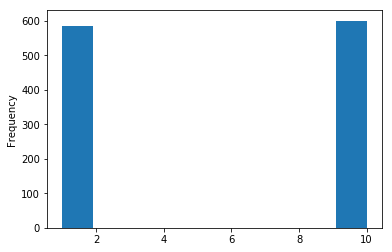

In [17]:
# class label distribution
df['label'].plot(kind='hist')

In [18]:
df['label'].value_counts()

10    600
1     584
Name: label, dtype: int64

Both classes have almost equal distribution.

**Data Preprocessing**

In [0]:
df['text'] = df['text'].str.replace("[^a-zA-Z]", " ")

In [20]:
# remove stop words
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# tokenization and removing stopwords
tokenized_doc = df['text'].apply(lambda x: x.split())

detokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

In [0]:
df['text'] = df['text'].apply(lambda x: " ".join([item for item in x.split() if item not in stop_words]))

In [0]:
# tokenization 
tokenized_doc = df['text'].apply(lambda x: x.split())

# remove stop-words 
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words]) 

# de-tokenization 
detokenized_doc = [] 
for i in range(len(df)): 
    t = ' '.join(tokenized_doc[i]) 
    detokenized_doc.append(t) 
df['text'] = detokenized_doc

In [22]:
df.head()

,text,label
0,From kkeller mail sas upenn edu Keith Keller S...,10
1,From nfotis ntua gr Nick C Fotis Subject Apr C...,1
2,From jwh sei cmu edu John Huber Subject Re NHL...,10
3,From jimg cybernet cse fau edu Jim Gorycki Sub...,10
4,From farenebt craft camp clarkson edu Droopy S...,10


In [0]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, stratify=df['label'], test_size = 0.4, random_state=12)

In [24]:
print(df_train.shape, df_test.shape)

(710, 2) (474, 2)


**Prepare data** in ULMFit language model format - using fastai library

In [0]:
# Language model data
data_lang_model = TextLMDataBunch.from_df(train_df = df_train, valid_df=df_test, path="")

In [28]:
data_lang_model

TextLMDataBunch;

Train: LabelList (710 items)
x: LMTextList
xxbos 10,xxbos 10,xxbos 1,xxbos 10,xxbos 10
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (474 items)
x: LMTextList
xxbos 1,xxbos 1,xxbos 10,xxbos 10,xxbos 10
y: LMLabelList
,,,,
Path: .;

Test: None

In [29]:
data_lang_model.train_ds

LabelList (710 items)
x: LMTextList
xxbos 10,xxbos 10,xxbos 1,xxbos 10,xxbos 10
y: LMLabelList
,,,,
Path: .

In [30]:
data_lang_model.valid_ds

LabelList (474 items)
x: LMTextList
xxbos 1,xxbos 1,xxbos 10,xxbos 10,xxbos 10
y: LMLabelList
,,,,
Path: .

In [31]:
# Classification data model
data_class = TextClasDataBunch.from_df(path="", train_df=df_train, valid_df = df_test, vocab=data_lang_model.train_ds.vocab, bs=32)

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:525: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
From rschmitt shearson com Robert Schmitt Subject Re Please Recommend D Graphics Library F Reply To rschmitt shearson com Organization Lehman Brothers Inc Lines What hardware plan run Workstation PC Cost level Run time licensing needs Bob, From clipper mccarthy csd uwo ca Khun Yee Fung Subject Re looking circle algorithm faster Bresenhams Organization Department Computer Science The University Western Ontario London Ontario Canada In Reply To graeme labtam labtam oz au message Wed Apr GMT Apr nwnexus WA COM Apr labtam labtam oz au Nntp Posting Host mccarthy csd uwo ca Lines Graeme Yes known Bresenhams Run Length Slice Algorithm Graeme Incremental lines See Fundamental Algorithms Computer Graphics Graeme Springer Verlag Berlin Heidelberg Graeme Hmm I think I help m

**Fine Tuning the pre-trained Model and Making prediction**

In [0]:
learner = language_model_learner(data_lang_model, pretrained=URLs.WT103, arch=AWD_LSTM, drop_mult=0.7)

In [35]:
# train the model with learning rate = 1e-2
learner.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,6.790457,5.360672,0.000670,00:00


In [36]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


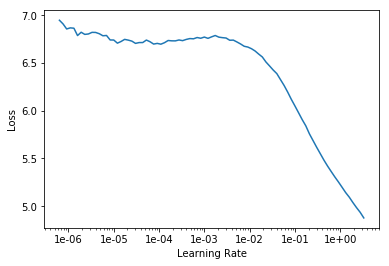

In [37]:
learner.recorder.plot()

In [0]:
#save this encoder to use it for classification later.
learner.save_encoder("ft_enc")

In [0]:
# using `data_class` object to build classifier with our fine-tuned encoder
learner = text_classifier_learner(data_class, arch=AWD_LSTM,drop_mult=0.7)

In [0]:
# again try fitting model
learner.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.724033,0.696688,0.500000,00:34
